In [129]:
import findspark
findspark.init('/home/ubuntu/spark-2.1.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('linear_regression_docs').getOrCreate()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Loading the two datasets
df = pd.read_csv("Datasets/forestfires.csv")
df_missing = pd.read_csv("Datasets/forestfires_missing.csv")

In [130]:
df.head()
df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,90.644681,110.872340,547.940039,9.021663,18.889168,44.288201,4.017602,0.021663,12.847292
std,2.313778,1.229900,5.520111,64.046482,248.066192,4.559477,5.806625,16.317469,1.791653,0.295959,63.655818
min,1.000000,2.000000,18.700000,1.100000,7.900000,0.000000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.200000,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,142.400000,713.900000,10.800000,22.800000,53.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,291.300000,860.600000,56.100000,33.300000,100.000000,9.400000,6.400000,1090.840000


In [131]:
#replacing outliers in FFMC, ISI, wind, DMC and RH columns with mean value
columns = ['FFMC', 'ISI', 'wind', 'DMC', 'RH']
for column in columns:
    mean = df.loc[:, column].mean()
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lowerRange = Q1 - 1.5*IQR
    upperRange = Q3 + 1.5*IQR
    df[column] = df[column].mask(df[column] > upperRange, other=mean)
    df[column] = df[column].mask(df[column] < lowerRange, other=mean)

In [132]:
df.describe()

,X,Y,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
count,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000,517.000000
mean,4.669246,4.299807,91.762994,105.371237,547.940039,8.536941,18.889168,43.194310,3.897154,0.021663,12.847292
std,2.313778,1.229900,1.863794,56.086837,248.066192,3.438339,5.806625,14.585978,1.616542,0.295959,63.655818
min,1.000000,2.000000,86.200000,1.100000,7.900000,0.400000,2.200000,15.000000,0.400000,0.000000,0.000000
25%,3.000000,4.000000,90.644681,68.600000,437.700000,6.500000,15.500000,33.000000,2.700000,0.000000,0.000000
50%,4.000000,4.000000,91.600000,108.300000,664.200000,8.400000,19.300000,42.000000,4.000000,0.000000,0.520000
75%,7.000000,5.000000,92.900000,137.000000,713.900000,10.100000,22.800000,52.000000,4.900000,0.000000,6.570000
max,9.000000,9.000000,96.200000,248.400000,860.600000,17.000000,33.300000,82.000000,8.000000,6.400000,1090.840000


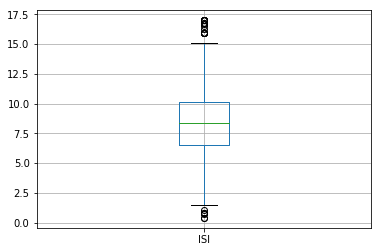

In [133]:
df.boxplot(column='ISI')